# Pytorch code percolation model with ResNet50

## parameter choices

In [5]:
myseed=111111
validation_split= 0.1
batch_size= 1024
num_epochs= 10
# mylr= 0.01
# mywd= 1e-6

datasrc  = '/storage/disqs/'+'ML-Data/Anderson/Images/'
#datasrc  = '/Users/danlo/Documents/PX319MLPhases_Data/'

method='3D-PyTorch-resnet50-'+str(myseed)+'-e'+str(num_epochs)
modelname = 'Model_'+method+'_'+'3D'+'.pth'
historyname = 'History_'+method+'_'+'3D'+'.pkl'
print(method,"\n",modelname,"\n",historyname)

3D-PyTorch-resnet50-111111-e10 
 Model_3D-PyTorch-resnet50-111111-e10_3D.pth 
 History_3D-PyTorch-resnet50-111111-e10_3D.pkl


## initializations

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
#seed=42
import torch
torch.manual_seed(myseed)
import numpy as np
np.random.seed(myseed+1)

In [8]:
from __future__ import print_function, division
# import os
print('torch version:',torch.__version__)
import sklearn
print('sklearn version:', sklearn.__version__)

torch version: 1.4.0
sklearn version: 0.23.2


In [17]:
import torchvision
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time
import os
import re
import copy

ModuleNotFoundError: No module named 'torchvision'

In [18]:
t=torch.Tensor()
print('current device: ', t.device, t.dtype, t.layout)

# switch to GPU if available
device=t.device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print('chosen device: ',device)

current device:  cpu torch.float32 torch.strided
chosen device:  cpu


## starting the main code

# Finding the Folders to train on

In [9]:
class MyImageFolder2(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(MyImageFolder2, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [10]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [11]:
os.getcwd()

'C:\\Users\\danlo\\Documents\\PX319MLPhases\\MachineLearning-Anderson\\src'

In [12]:
def set_new_training_data(datapath):

    global training_set
    training_set=0
    global validation_set
    validation_set=0
    # dataname='L20-100-s100'
    # path='../../../../../../../media/phrhmb/Datasets_DisQS/'+dataname
    # path='/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname

    global transform
    transform=transforms.Compose([torchvision.transforms.Resize((32,32)),
                                  torchvision.transforms.ToTensor()])


    #path = datapath 
    global whole_dataset
    whole_dataset=MyImageFolder2(root=datapath, transform=transform)


    global data_size
    data_size = len(whole_dataset)
    print(data_size)
    # validation_split=0.1
    global split
    split=int(np.floor(validation_split*data_size))
    global training
    training=int(data_size-split)
    # split the data into training and validation
    training_set, validation_set= torch.utils.data.random_split(whole_dataset,(training,split))


    # batch_size=1024
    global train
    train = torch.utils.data.DataLoader(
            dataset=training_set,
            batch_size=batch_size,
            shuffle=True)
    # enum_train=enumerate(train)
    # len_train=len(train)

    global val
    val = torch.utils.data.DataLoader(
            dataset=validation_set,
            batch_size=batch_size,
            shuffle=False)
    # enum_val=enumerate(val)
    # len_val=len(val)
    # print(len_train,len_val)


    global class_names
    class_names =whole_dataset.classes
    class_names


    global inputs,labels,path
    inputs,labels,path= next(iter(val))
    labels.shape


    global img_sizeX,img_sizeY
    img_sizeX,img_sizeY= inputs.shape[-1],inputs.shape[-2]
    img_sizeY


    global num_of_train_samples
    num_of_train_samples = len(training_set) # total training samples
    global num_of_test_samples
    num_of_test_samples = len(validation_set) #total validation samples
    global steps_per_epoch
    steps_per_epoch = np.ceil(num_of_train_samples // batch_size)
    global len_train
    len_train=len(train)
    global len_val
    len_val=len(val)
    global number_classes
    number_classes= len(class_names)
    print('number of samples in the training set:', num_of_train_samples)
    print('number of samples in the validation set:', num_of_test_samples )
    print('number of samples in a batch',len_train) 
    print('number of samples in a batch',len_val)
    print('number of classes',number_classes )
    
    global model
    model=models.resnet50(pretrained=True, progress=True)     #Change this

    global num_ftrs
    num_ftrs = model.fc.in_features # number of input features of the last layer which is fully connected (fc)

    #We modify the last layer in order to have 2 output: percolating or not
    model.fc=nn.Linear(num_ftrs, number_classes )
     #the model is sent to the GPU
    model = model.to(device)
    
    # defining the optimizer

    global optimizer
    optimizer=torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    # defining the loss function
    global criterion
    criterion = nn.CrossEntropyLoss()

    global exp_lr_scheduler
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()

    #print(model)
    
    #the model is sent to the GPU
    model = model.to(device)

## building the CNN

In [13]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [14]:
# for param in model.parameters():
#     print(param.shape)

In [15]:
def train_model(model,criterion, optimizer, num_epochs, scheduler, batch_size):
    global accuracy, _loss, val_accuracy, val_loss, epochs, val_epochs 
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracy=[]
    _loss=[]
    val_accuracy=[]
    val_loss=[]
    epochs=[]
    val_epochs=[]
       
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('-' * 10)
        
        #two phases: training and validating
        for phase in [train,val]:
            if phase == train:
                print('Training', end=" ")
                model.train() # set the model to training mode
                batches= len_train
            else:
                print('Validation', end=" ")
                model.eval() # set the model to evaluation mode
                batches= len_val
                
            #batches= len(list(enum_data))
            print('with', batches, 'batches')
            running_loss=0.0
            running_corrects=0.0
            
            # Here's where the training happens
            # print('--- iterating through data ...')
            
            for i, (inputs,labels,paths) in enumerate(phase):
                
                print(i*100//batches, '%', end="\r", flush=True)
                
                inputs=inputs.to(device)
                labels=labels.to(device)
                #paths=paths.to(device)
                                
                #put the gradient to zero to avoid accumulation during back propagation
                optimizer.zero_grad()
                                
                #now we need to carry out the forward and backward process in different steps
                #First the forward training
                #for the training step we need to log the loss
                with torch.set_grad_enabled(phase==train):
                    outputs=model(inputs)
                    _, preds= torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                
                #still for the training phase we need to implement backword process and optimization
                
                    if phase==train:
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                #loss.item() extract the loss value as float then it is multiply by the batch size
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+= torch.sum(preds==labels.data)
                
            if phase == train:
                scheduler.step()            
            
            if phase == train:
                epoch_loss= running_loss/len(phase.dataset)
                epoch_acc = running_corrects.double()/ len(phase.dataset)
                print('{} loss= {:4f}, accuracy= {:4f}'.format(
                    'Training result:', epoch_loss, epoch_acc))
                accuracy.append(epoch_acc)
                _loss.append(epoch_loss)
                epochs.append(epoch)
                
            if phase == val:
                epoch_loss= running_loss/len(val.dataset)
                epoch_acc = running_corrects.double()/len(val.dataset)
                print('{} val_loss= {:4f}, val_accuracy= {:4f}'.format(
                    'Validation result:', epoch_loss, epoch_acc))
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)
                val_epochs.append(epoch)
                
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model        

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):

            inputs=inputs.to(device)
            labels=labels.to(device)

            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                imshow(inputs.cpu().data[j])
                
                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
def visualize_model_misclassified(model, num_images=6): #gives shows only the misclassified images
    import re
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                if labels[j]!=preds[j] and abs(labels[j]-preds[j])>4:
                #print(inputs.size()[0])
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                    imshow(inputs.cpu().data[j])
                
                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        
        model.train(mode=was_training)

# Creating Random 3D Data

In [16]:
N = 10    #Number of sample 3D systems
tensors = []
for i in range(N):
    ten = [
        [
            [1,1,1],    
            [1,1,1],    #Layer 0
            [1,1,1]
        ],
        [
            [1,1,1],
            [1,1,1],    #Layer 1
            [1,1,1]
        ],
        [
            [1,1,1],
            [1,1,1],    #Layer 2
            [1,1,1]
        ]
    ]
    tensors.append(ten)
tensors = torch.Tensor(tensors)
print(tensors)

labels = []
labels = torch.randn(N,1)

dataset = torch.utils.data.TensorDataset(tensors, labels)
loader = torch.utils.data.DataLoader(dataset,batch_size=2)
print(dataset)
print(loader)

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
      

17000
number of samples in the training set: 15300
number of samples in the validation set: 1700
number of samples in a batch 15
number of samples in a batch 2
number of classes 17
L50-1000-s200 
 /storage/disqs/ML-Data/Anderson/Images/L50-1000-s200
PyTorch-resnet50-111111-e10 
 Model_PyTorch-resnet50-111111-e10_L50-1000-s200.pth 
 History_PyTorch-resnet50-111111-e10_L50-1000-s200.pkl
./L50-1000-s200/ ./L50-1000-s200/Model_PyTorch-resnet50-111111-e10_L50-1000-s200.pth ./L50-1000-s200/History_PyTorch-resnet50-111111-e10_L50-1000-s200.pkl
Epoch 1/10
----------
Training with 15 batches
Training result: loss= 2.885972, accuracy= 0.120065
Validation with 2 batches
Validation result: val_loss= 6.091346, val_accuracy= 0.096471

Epoch 2/10
----------
Training with 15 batches
Training result: loss= 2.383385, accuracy= 0.169804
Validation with 2 batches
Validation result: val_loss= 3.817094, val_accuracy= 0.111176

Epoch 3/10
----------
Training with 15 batches
Training result: loss= 2.303934, a

Validation result: val_loss= 2.255400, val_accuracy= 0.190588

Epoch 10/10
----------
Training with 15 batches
Training result: loss= 2.073610, accuracy= 0.242484
Validation with 2 batches
Validation result: val_loss= 2.253213, val_accuracy= 0.190588

Training complete in 10m 56s
Best val Acc: 0.198824
[tensor(0.1165, device='cuda:0', dtype=torch.float64), tensor(0.1571, device='cuda:0', dtype=torch.float64), tensor(0.1335, device='cuda:0', dtype=torch.float64), tensor(0.1100, device='cuda:0', dtype=torch.float64), tensor(0.1224, device='cuda:0', dtype=torch.float64), tensor(0.1565, device='cuda:0', dtype=torch.float64), tensor(0.0994, device='cuda:0', dtype=torch.float64), tensor(0.1988, device='cuda:0', dtype=torch.float64), tensor(0.1906, device='cuda:0', dtype=torch.float64), tensor(0.1906, device='cuda:0', dtype=torch.float64)]
0.19058823529411764
8501
number of samples in the training set: 7651
number of samples in the validation set: 850
number of samples in a batch 8
number of 

Training result: loss= 2.098894, accuracy= 0.229267
Validation with 8 batches
Validation result: val_loss= 11.750565, val_accuracy= 0.141165

Epoch 6/10
----------
Training with 64 batches
Training result: loss= 2.089019, accuracy= 0.232395
Validation with 8 batches
Validation result: val_loss= 3.491603, val_accuracy= 0.093785

Epoch 7/10
----------
Training with 64 batches
Training result: loss= 2.076103, accuracy= 0.234702
Validation with 8 batches
Validation result: val_loss= 2.281270, val_accuracy= 0.192726

Epoch 8/10
----------
Training with 64 batches
Training result: loss= 2.023476, accuracy= 0.247925
Validation with 8 batches
Validation result: val_loss= 2.075924, val_accuracy= 0.239270

Epoch 9/10
----------
Training with 64 batches
Training result: loss= 1.975811, accuracy= 0.261659
Validation with 8 batches
Validation result: val_loss= 2.151596, val_accuracy= 0.223523

Epoch 10/10
----------
Training with 64 batches
Training result: loss= 1.960177, accuracy= 0.264183
Valida

Training result: loss= 2.550495, accuracy= 0.144222
Validation with 9 batches
Validation result: val_loss= 2.356584, val_accuracy= 0.159765

Epoch 2/10
----------
Training with 75 batches
Training result: loss= 2.354530, accuracy= 0.162379
Validation with 9 batches
Validation result: val_loss= 3.226640, val_accuracy= 0.143059

Epoch 3/10
----------
Training with 75 batches
Training result: loss= 2.328739, accuracy= 0.168458
Validation with 9 batches
Validation result: val_loss= 2.873742, val_accuracy= 0.153412

Epoch 4/10
----------
Training with 75 batches
Training result: loss= 2.314351, accuracy= 0.172275
Validation with 9 batches
Validation result: val_loss= 2.574473, val_accuracy= 0.163294

Epoch 5/10
----------
Training with 75 batches
Training result: loss= 2.304240, accuracy= 0.174131
Validation with 9 batches
Validation result: val_loss= 2.327739, val_accuracy= 0.162941

Epoch 6/10
----------
Training with 75 batches
Training result: loss= 2.284644, accuracy= 0.177961
Validati

8501
number of samples in the training set: 7651
number of samples in the validation set: 850
number of samples in a batch 8
number of samples in a batch 1
number of classes 17
L30-500-s200 
 /storage/disqs/ML-Data/Anderson/Images/L30-500-s200
PyTorch-resnet50-111111-e10 
 Model_PyTorch-resnet50-111111-e10_L30-500-s200.pth 
 History_PyTorch-resnet50-111111-e10_L30-500-s200.pkl
./L30-500-s200/ ./L30-500-s200/Model_PyTorch-resnet50-111111-e10_L30-500-s200.pth ./L30-500-s200/History_PyTorch-resnet50-111111-e10_L30-500-s200.pkl
Epoch 1/10
----------
Training with 8 batches
Training result: loss= 3.138624, accuracy= 0.066135
Validation with 1 batches
Validation result: val_loss= 2.940701, val_accuracy= 0.055294

Epoch 2/10
----------
Training with 8 batches
Training result: loss= 2.868554, accuracy= 0.104692
Validation with 1 batches
Validation result: val_loss= 108.739265, val_accuracy= 0.077647

Epoch 3/10
----------
Training with 8 batches
Training result: loss= 2.648252, accuracy= 0.127

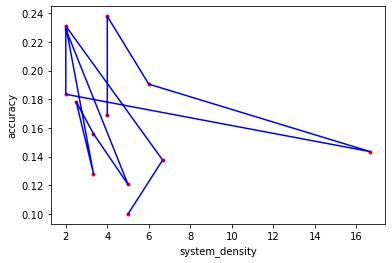

In [18]:
# num_epochs=10
val_accuracy_list = []
val_loss_list     = []

myepochs = num_epochs

for image_index in image_categories: 
    img_sizeY= img_sizeX

    dataname=image_index
    
    #datasrc  = '/storage/disqs/'+'ML-Data/Anderson/Images/'
    #datapath = datasrc+dataname # SC-RTP
    datapath = datasrc+dataname # Local Machine (Laptop)
    devhomepath = '/home/epp/phupqr/PX319MLPhases/'
    
    set_new_training_data(datapath)

    print(dataname,"\n",datapath)

    modelname = 'Model_'+method+'_'+dataname+'.pth'
    historyname = 'History_'+method+'_'+dataname+'.pkl'
    print(method,"\n",modelname,"\n",historyname)

    savepath = './'+dataname+'/'
    import os
    try:
        os.mkdir(savepath)
    except FileExistsError:
        pass

    modelpath = savepath+modelname
    historypath = savepath+historyname
    print(savepath,modelpath,historypath)
    base_model = train_model(
        model, criterion, optimizer,num_epochs,exp_lr_scheduler,batch_size=batch_size )
    val_accuracy_list.append(val_accuracy[-1].item())
    print(val_accuracy)
    print(val_accuracy[-1].item())
    val_loss_list.append(val_loss[-1])
print("val_accuracy:", val_accuracy_list)
print("val_loss:", val_loss_list)
fig=plt.figure()
plt.plot(pixel_density, val_accuracy_list, '.r')
plt.plot(pixel_density, val_accuracy_list, '-b')
plt.ylabel('accuracy')
plt.xlabel('system_density')
plt.show()
fig.savefig(devhomepath + 'MachineLearning-Anderson/src/plots/performance_metrics/' + 'sys_density_val_accuracy-' + 'e' + str(myepochs) + '-' + 'seed_' + str(myseed) + '.png') 

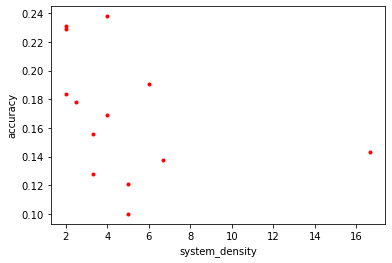

In [19]:
fig=plt.figure()
plt.plot(pixel_density, val_accuracy_list, '.r')
plt.ylabel('accuracy')
plt.xlabel('system_density')
plt.show()
fig.savefig(devhomepath + 'MachineLearning-Anderson/src/plots/performance_metrics/' + 'sys_density_val_accuracy-' + 'e' + str(myepochs) + '-' + 'seed_' + str(myseed) + '.png') 

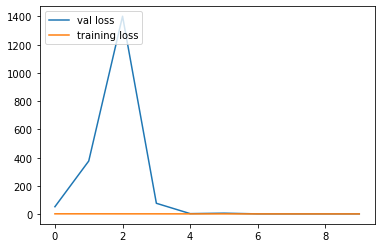

In [20]:
fig=plt.figure()
plt.plot(epochs,val_loss, label='val loss')
plt.plot(epochs,_loss, label='training loss')
plt.legend(loc='upper left')
fig.savefig(savepath+method+'_'+method+'_'+dataname+'_loss'+'.png')

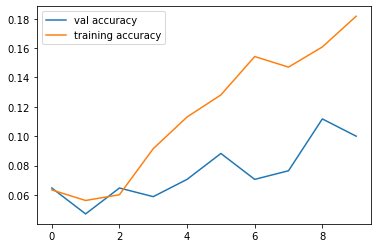

In [21]:
fig=plt.figure()
plt.plot(val_epochs,val_accuracy, label='val accuracy')
#print(val_accuracy[0].item())
plt.plot(epochs,accuracy, label='training accuracy')
plt.legend(loc='upper left')
fig.savefig(savepath+method+'_'+method+'_'+dataname+'_accuracy'+'.png')

In [22]:
# PATH = './Anderson_'+dataname+'_resnet50_'+str(num_epochs)+'_epochs_batch_size'+str(batch_size)+'.pth'
torch.save(model.state_dict(), modelpath)

## testing the quality of the learned model

Accuracy of W15.0 :  0 %
Accuracy of W15.25 : 44 %
Accuracy of W15.5 : 40 %
Accuracy of W15.75 :  0 %
Accuracy of W16.0 :  0 %
Accuracy of W16.2 :  0 %
Accuracy of W16.3 :  0 %
Accuracy of W16.4 :  0 %
Accuracy of W16.5 :  0 %
Accuracy of W16.6 :  0 %
Accuracy of W16.7 : 30 %
Accuracy of W16.8 :  0 %
Accuracy of W17.0 :  0 %
Accuracy of W17.25 : 12 %
Accuracy of W17.5 :  0 %
Accuracy of W17.75 :  0 %
Accuracy of W18.0 : 63 %
17


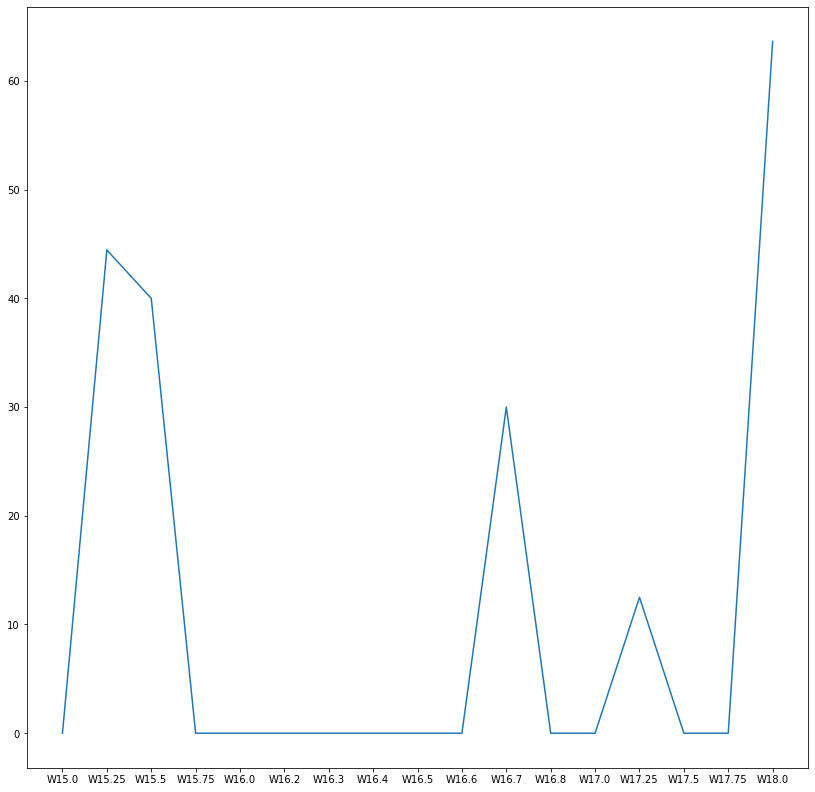

In [23]:
class_correct = list(0. for i in range(number_classes))
class_total = list(0. for i in range(number_classes))
accuracy=list(0. for i in range(number_classes))
average=list(0. for i in range(number_classes))
with torch.no_grad():
     for i, (data) in enumerate(val):
        inputs=data[0]
        labels=data[1]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 

        c = (preds == labels).squeeze()
        for i in range(inputs.size()[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(number_classes):
    average[i]=(class_correct[i] / class_total[i])*100
    
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

print(len(average))
#fig=plt.figure()
plt.figure(figsize=(14,14))
plt.plot(class_names,average)
plt.savefig(savepath+method+'_'+dataname+'_classacc'+'.png')

In [24]:
@torch.no_grad()
def simple_confusion_matrix(model,loader):
    confusion_matrix = torch.zeros(number_classes, number_classes)
    for i, (data) in enumerate(loader):
        inputs=data[0]
        labels=data[1]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                
    return confusion_matrix

In [25]:
cm=simple_confusion_matrix(model,val)
cm

tensor([[0., 4., 5., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 4., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
        [0., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 4., 3., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 1., 0., 2.],
        [0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.],
        [0., 1., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1.],
        [0., 4., 8., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 4.],
        [0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 3.],
        [0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 3.],
        [0., 2., 5., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 3.],
        [0., 2., 1., 1., 1., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0., 0., 1.],
        [0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,

In [26]:
def confusion_matrix_torch(cm, target_names,cmap=None,title='Confusion Matrix'):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    #accuracy = np.trace(cm) / float(np.sum(cm))
    #misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig=plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)#,fontsize=40)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=30)
        plt.yticks(tick_marks, target_names,fontsize=30)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if  cm[i, j] == 0 or cm[i, j] > thresh else "black") 

#     fig=plt.figure()
    plt.tight_layout()
    plt.ylabel('True label',fontsize=40)
    plt.xlabel('Predicted label',fontsize=40)
#     plt.show()
    plt.savefig(savepath+method+'_'+dataname+'_CM'+'.png')
    plt.show()

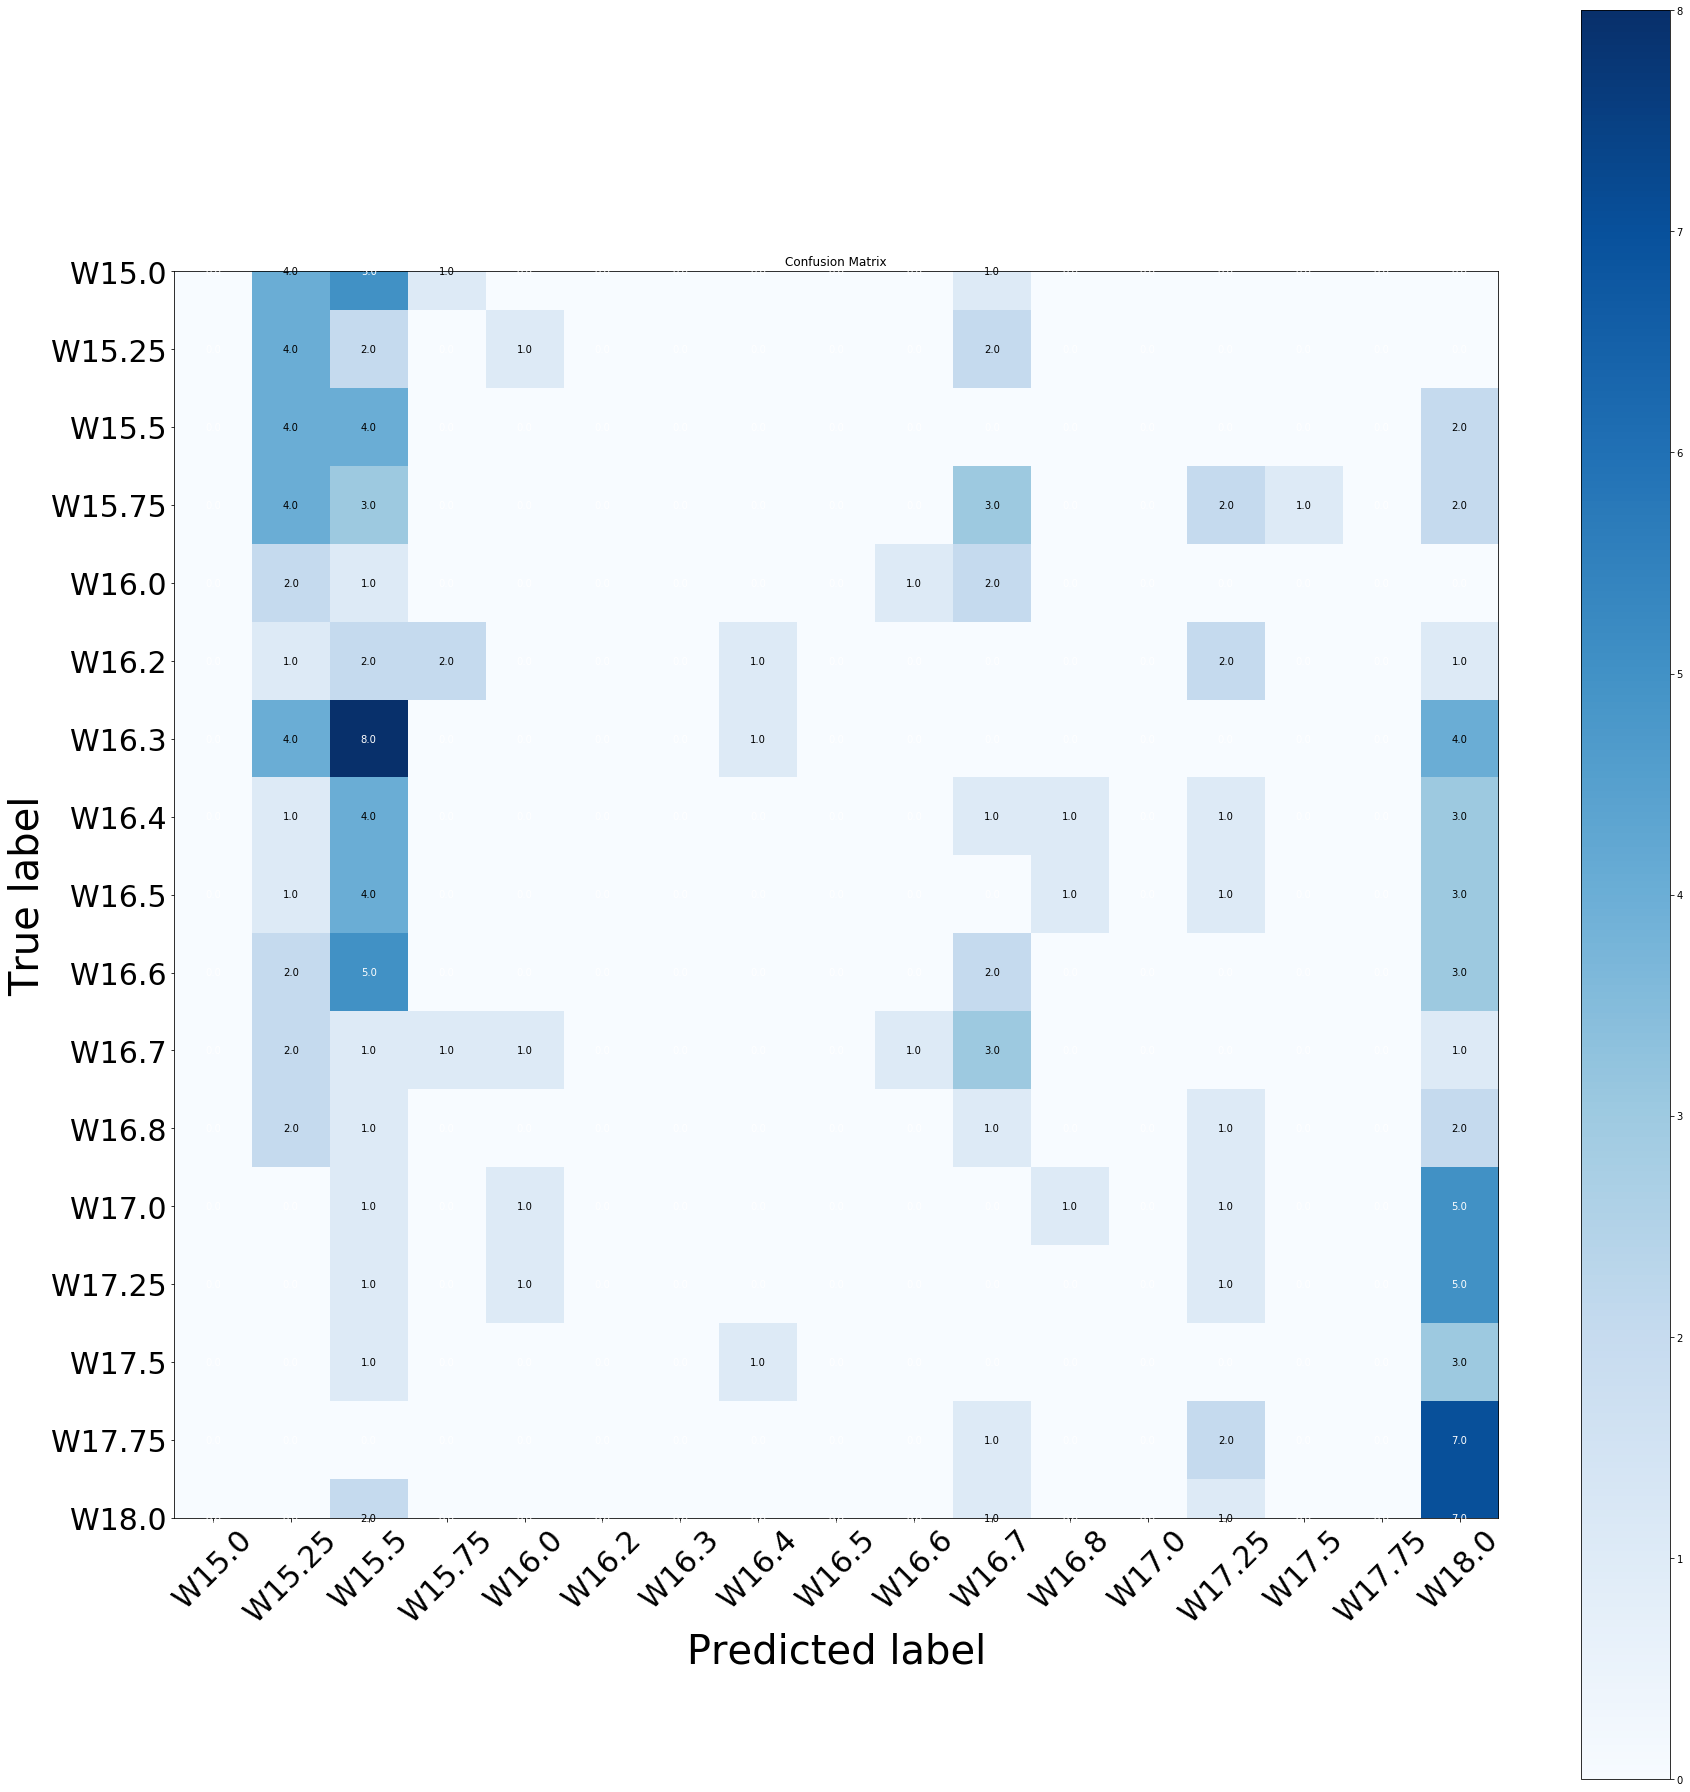

In [27]:
confusion_matrix_torch(cm,class_names)

In [ ]:
%%javascript
IPython.notebook.save_notebook()